# Planet Labs Image Selection Demo

In [1]:
from timbr import Snapshot
data = Snapshot("/Users/chelm/.timbr/data/San Diego Image Metadata (Planet Labs - RapidEye).h5")

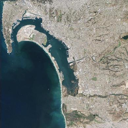

2016-03-24T19:06:55.000000Z 20160324_190655_1154114_RapidEye-3


In [2]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import Image, display
import base64 as b64

@interact(i=widgets.IntSlider(min=0,max=len(data)-1,step=1,value=0))
def f(i):
    img = data[i][-1]
    display(Image(data=b64.b64decode(img["thumbnail"]["__data__"]), width=250, height=250))
    print img['properties']['acquired'], img['id']

In [814]:
scene_ids = [
    "20160324_190655_1154114_RapidEye-3",
    "20150326_192901_1154114_RapidEye-5",
    "20140403_193228_1154114_RapidEye-5",
    "20131125_192646_1154114_RapidEye-5",
    "20151212_191210_1154114_RapidEye-5"
]

## Downloading Geotiffs

./san_diego_4_11_16/visual/20160324_190655_1154114_RapidEye-3_visual.tif


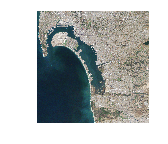

./san_diego_4_11_16/visual/20150326_192901_1154114_RapidEye-5_visual.tif


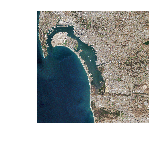

./san_diego_4_11_16/visual/20140403_193228_1154114_RapidEye-5_visual.tif


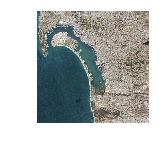

./san_diego_4_11_16/visual/20131125_192646_1154114_RapidEye-5_visual.tif


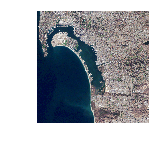

./san_diego_4_11_16/visual/20151212_191210_1154114_RapidEye-5_visual.tif


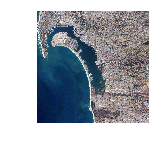

In [815]:
from planet import api
import sys, os
import urllib2, httplib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class NoRedirection(urllib2.HTTPErrorProcessor):
    def http_response(self, request, response):
        return response
    https_response = http_response

opener = urllib2.build_opener(NoRedirection)

def get_image(scene, scene_type='visual', data_dir="./planet_images"):
    img_dir = os.path.join(data_dir, scene_type)
    if not os.path.exists( img_dir ):
        os.makedirs(img_dir)
        
    url = scene['properties']['data']['products'][scene_type]['full']
    
    filename = os.path.join(img_dir, '%s_%s.tif' % (scene['id'], scene_type)) 
    req = urllib2.Request(url, headers={"Authorization": "api-key %s" % api_key})
    response = opener.open(req)
    
    if 'Location' in response.headers:
        redirect_url = response.headers['Location']
        req = urllib2.Request(redirect_url)
        response = opener.open(req)
    
    CHUNK = 16 * 1024
    total = 0
    with open(filename, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                sys.stdout.flush()
                sys.stdout.write('why?')
                break
                
            total += CHUNK
            sys.stdout.flush()
            sys.stdout.write('\r>> Downloading %s %d' % (filename, total))
            f.write(chunk)
            
            
scenes     = {s['id']: s for i, s in data }
api_key    = "65a347d4358348189a800a5eac3bcde7"
data_dir   = './san_diego_4_11_16'
scene_type = 'visual'                    
scene_meta = [ scenes[i] for i in scene_ids ]
    
for scene in scene_meta:
    filename = os.path.join(data_dir, scene_type, scene['id'] + '_' + scene_type + '.tif')
    if not os.path.exists(filename):
        get_image(scene, scene_type=scene_type, data_dir=data_dir)
        
    print filename
    fig, ax = plt.subplots(1, figsize=(2,2), facecolor='white')
    ax.axis('off')
    imgplot = plt.imshow(mpimg.imread(filename))
    plt.show() 
     

## Clipping Imagery to the San Diego Naval Base

To compare each image we first clip each one to the same area. We use a BBOX to select array indices that extract an area of interest from each image and stores them as a Numpy nd-array. 

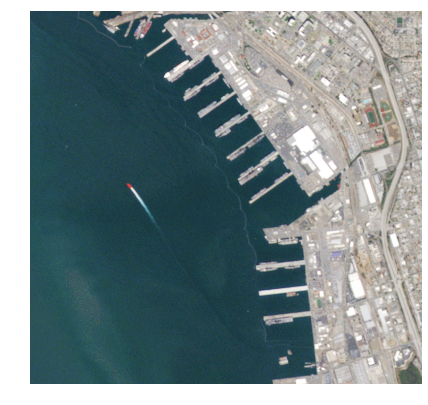

In [73]:
import os
import rasterio
import matplotlib.image as mpimg

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib.cm as cm 


def xy_from_coords(x_coord, y_coord, ul, lr, width, height):
    x0, x1 = ul[0], lr[0]
    y0, y1 = ul[1], lr[1]
    x_diff = x1 - x0
    y_diff = y0 - y1
    xpx =  ((x1 - x_coord) / x_diff) * width
    if y0 - y_coord == 0.0:
        ypx = height
    elif y_diff != 0:
        ypx = (y0 - y_coord) / y_diff * height
    else:
        ypx = 0
    return int(abs(xpx-width)), int(ypx)


def clip_image(bbox, filepath):
    with rasterio.drivers():
        with rasterio.open(filepath) as src:
            bounds = src.bounds
            ul, lr = [bounds.left, bounds.top], [bounds.right, bounds.bottom]
            r, g, b, a = src.read()
            np_img = np.dstack((r, g, b, a))
            ul_px = xy_from_coords(bbox[0], bbox[3], ul, lr, src.width, src.height)
            lr_px = xy_from_coords(bbox[2], bbox[1], ul, lr, src.width, src.height)
            return np_img[ul_px[0]:lr_px[0], ul_px[1]:lr_px[1], :]
        
            

bbox = [483275.7009112152, 3610083.6489744713, 486785.39847831125, 3613762.760762966]

data_dir = './san_diego_4_11_16/visual/'
files = os.listdir(data_dir)
clipped = [clip_image(bbox, os.path.join( data_dir, f )) for f in files]
render_array(clipped[-1])

In [67]:
def render_array(arr1, arr2=None, width=7, height=7, cmap=plt.cm.jet):
    if arr2 is None:
        fig, ax = plt.subplots(1, figsize=(width,height), facecolor='white')
        ax.axis('off')
        plt.imshow(arr1, cmap=cmap)
        plt.show()
    else: 
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(width, height)
        ax1.imshow(arr2)
        ax1.axis('off')
        ax2.imshow(arr1)
        ax2.axis('off')         

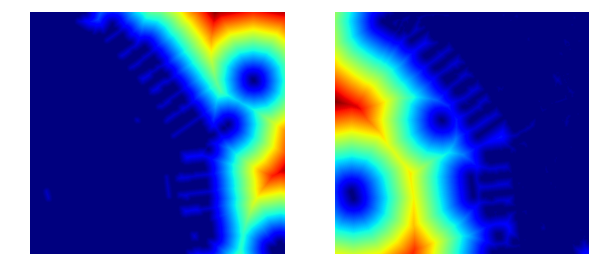

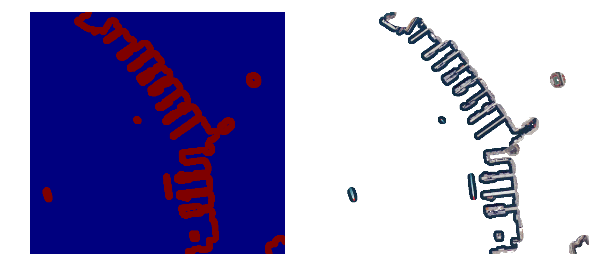

In [290]:
import cv2
import numpy as np
from IPython.display import Image, display

def buffer_coastline(img, threshold=135, x=100, y=300):
    arr = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.ndarray(arr.shape + (3,)).astype(np.uint8)
    below = arr < threshold
    mask[below] = [255,255,255]
    mask = cv2.morphologyEx(mask[:,:,0], cv2.MORPH_OPEN, kernel=np.ones([3, 3]), iterations=3)
    edm1 = cv2.distanceTransform(mask, cv2.cv.CV_DIST_L2, 5)
    s = (edm1 < 10)
    mask[s] = 255
    mask[~s] = 0
    edm2 = cv2.distanceTransform(mask, cv2.cv.CV_DIST_L2, 5)
    s = (edm2 < 20) & (edm1 < 10)
    mask[s] = 255
    mask[~s] = 0
    return mask, edm1, edm2
                                 
    
img = np.copy(clipped[3][:,:,0:3])
mask, edm1, edm2 = buffer_coastline(img.copy())
render_array(edm1, edm2, width=10, height=10)

img = np.copy(clipped[3])
img[:,:,3] = mask
render_array(img, mask, width=10, height=10)


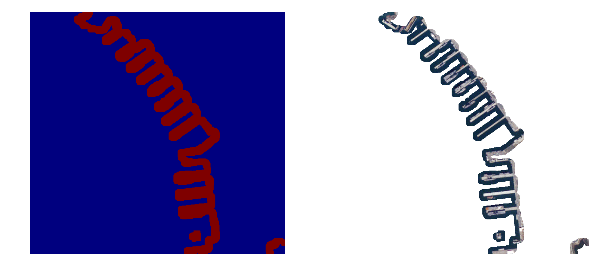

In [291]:
masks = []
for image_arr in clipped:
    avg = np.average(np.copy(image_arr[:,:,0:2]), axis=2)
    mask, edm1, edm2 = buffer_mask(avg, threshold=125)
    masks.append(mask)
    
union_mask = reduce( lambda s,e: s & e, masks )
union_mask = cv2.dilate(union_mask, kernel=np.ones([3, 3]), iterations=3)
binary_mask = union_mask.copy() 
binary_mask[(union_mask > 0)] = 1

img = clipped[3].copy()
img[:,:,3] = union_mask

render_array(img, union_mask, cmap=plt.cm.gray, width=10, height=10)


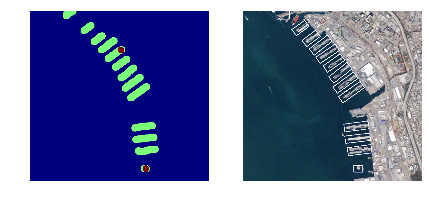

In [274]:

from skimage import measure
from skimage.measure import regionprops
from skimage.morphology import skeletonize, convex_hull_image, medial_axis, opening
from scipy import ndimage

def seg_buffer(im, dist=15):
    mask = im.copy()
    edm1 = cv2.distanceTransform(~im, cv2.cv.CV_DIST_L2, 5)
    s = (edm1 < dist)
    mask[s] = 1
    return mask, edm1

skel = skeletonize(binary_mask).astype(np.int)
#render_array(~skel, width=5, height=5, cmap=plt.cm.gray)

k = np.array([[1,1,1],[1,0,1],[1,1,1]])
ngrid = ndimage.convolve(skel, k, mode='constant') * skel
ngrid[ngrid > 2] = 0
ngrid[(ngrid <= 2) & (ngrid > 0)] = 1

segment_labels = measure.label(ngrid)
segment_props = measure.regionprops(segment_labels)

i=0
buffers = []
for seg in segment_props:
    i += 1
    if (seg.orientation < 0 
        or seg.orientation > 1 
        or seg.solidity < 0.1):
        continue

    buff, edm1 = seg_buffer((segment_labels == i).astype(np.uint8) * 255, dist=15)
    buffers.append(buff)

buffer_sum = reduce( lambda s,e: s + e, buffers )

contours, hierarchy = cv2.findContours( buffer_sum.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
vis = clipped[0].copy()

regions = []
for i, cnt in enumerate(contours):
    if cv2.contourArea(cnt) > 0.0:
        rect = cv2.minAreaRect(cnt)
        box = cv2.cv.BoxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(vis,[box],0,(0,0,255),2)
        regions.append({ 'box': box, 'rect': rect, 'bounds': cv2.boundingRect(cnt)})
        #cv2.rectangle(vis,(x,y),(x+w,y+h),0,2)
    
render_array(vis, buffer_sum)

def crop_region(region, img):
    rect = region['rect']
    center = rect[0]
    angle = rect[2]
    size = rect[1]
    size = (int(size[0]), int(size[1]))
     
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    warped = cv2.warpAffine(img, M, dsize=img[:,:,0].shape, flags=cv2.INTER_CUBIC)
    crop = np.ndarray((size[1],size[0],4))

    for i in xrange(4):
        crop[:,:,i] = cv2.getRectSubPix(warped[:,:,i], size, center)

    return crop.astype(np.uint8)


image_regions = [[crop_region(region, img.copy()) for region in regions[1:-2]] for img in clipped]
#render_array(image_regions[3][2], image_regions[4][2])

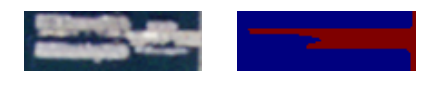

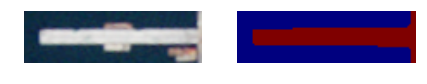

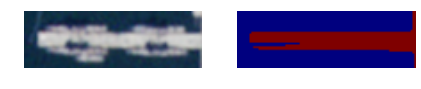

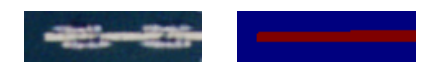

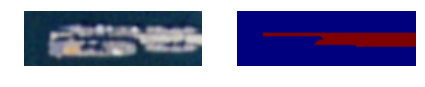

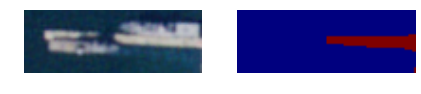

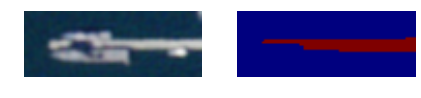

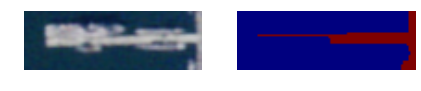

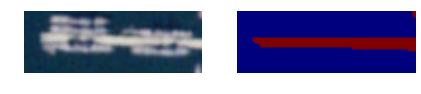

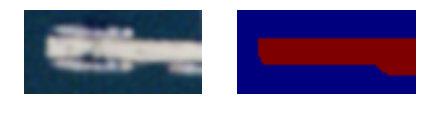

In [275]:

def threshold_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    darker = cv2.equalizeHist(gray)
    ret,thresh = cv2.threshold(darker,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    newimg = cv2.bitwise_not(thresh)
    return ~newimg

def threshold_mask2(img, threshold=150):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.ones(gray.shape).astype(np.uint8)
    mask[gray < threshold] = 0
    return mask

def scanline_mask(imask):
    mask = np.ndarray(imask.shape)

    for l in xrange(imask.shape[0]):
        line = imask[l,:]
        labels = measure.label(line)
        land = labels[-1]
        if land == 1:
            mask[l,:] = labels
        else:
            labels[ labels != land ] = 0
            labels[ labels > 0 ] = 1
            mask[l,:] = labels

    return (mask >= 1).astype(np.uint8)


def saturation_mask(img, threshold=170):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    normalize = lambda x: (255 / (x.max() - x.min())) * (x - x.min())
    smooth = lambda x: ndimage.convolve(x, np.ones([3,3])/9)
    
    normS = ndimage.convolve(~normalize(smooth(gray[:,:,1])), np.ones([3,3])/9)
    mask = normS > threshold
    return mask
    


region_masks_all = []
region_masks = []
for r in xrange(len(image_regions[0])):
    _masks = []
    for i in xrange(len(image_regions)):
        img = image_regions[i][r].copy()
        #mask = threshold_mask( img )
        mask = hsv_mask( img )
        _masks.append( mask )
        
    region_masks_all.append(_masks)
    r_mask = scanline_mask( reduce( lambda s,e: s & e, _masks ) )
    render_array(r_mask, image_regions[0][r])
    region_masks.append(r_mask)



Region: 2
image: 0 Objects: 3


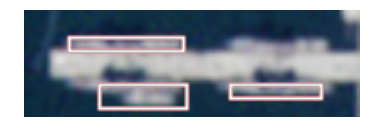

image: 1 Objects: 4


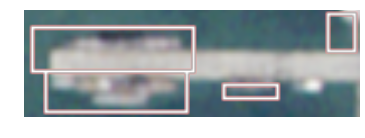

image: 2 Objects: 4


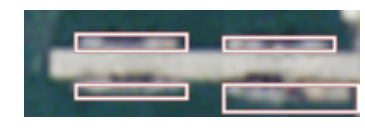

image: 3 Objects: 4


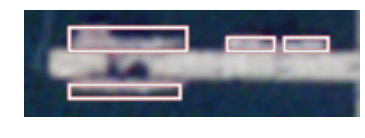

image: 4 Objects: 3


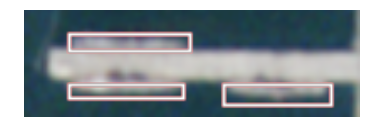

In [286]:
from skimage.morphology import binary_opening

total = 0
threshold = 170

def find_objects(r, r_img, show=False):
    vis = r_img.copy()
    #t_mask = threshold_mask2( r_img, threshold=threshold )
    t_mask = hsv_mask( r_img, threshold=threshold )

    mask = region_masks[r].copy()
    #render_array(vis, t_mask)
    
    diff = mask - t_mask
    diff[ diff < 255 ] = 0
    diff = binary_opening(diff).astype(np.uint8)
    
    labels = measure.label(diff)
    props = measure.regionprops(labels)
    
    if show == True:
        render_array(vis, labels)
    
    contours, hierarchy = cv2.findContours(diff.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    filter_contours = []
    areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 20.0: 
            areas.append(area)
            filter_contours.append(cnt)
            cv2.drawContours(vis, cnt, -1, (255,0,0), 2)
    return filter_contours, areas
    
    
found_objects = []
for i, regions in enumerate(image_regions):
    region_objs = []
    for r, img in enumerate(regions):
        contours, areas = find_objects(r, img.copy())
        cnt = len(contours)
        total += cnt
        region_objs.append({'areas': areas, 'contours': contours, 'count': cnt})
    found_objects.append(region_objs) 
    
 
    
def show_region(r):
    print 'Region:', r
    counts = []
    for i, image in enumerate(image_regions): 
        objects = found_objects[i][r]
        print 'image:', i, 'Objects:', objects['count']
        counts.append(objects['count'])
        vis = image[r].copy()
        for cnt in objects['contours']:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(vis,(x,y),(x+w,y+h),(255,0,0),1)
        render_array(vis, width=6, height=6)    



#c, a = find_objects(2, image_regions[0][2], show=True)        
show_region(2)     

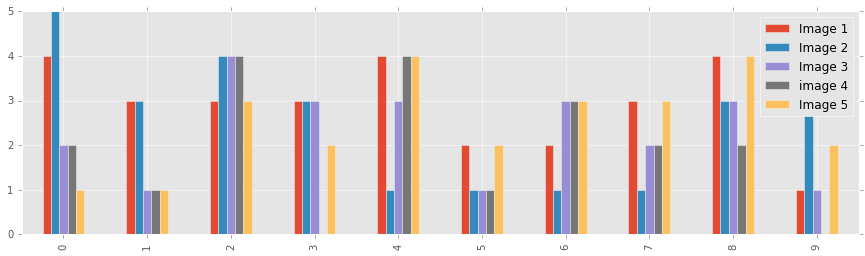

In [310]:
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

cnts = [[o['count'] for o in img] for img in found_objects]

df2 = pd.DataFrame(np.array(cnts).transpose(), columns=['Image 1', 'Image 2', 'Image 3', 'image 4','Image 5'])
df2.plot.bar(figsize=(15, 4))
plt.show()
